# Energy consumption prediction
* Brocco Mattia **|** 873058
* Piccolo Giulio **|** 87472

In [3]:
import statistics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split 
import lightgbm as lgb
from pprint import pprint
import warnings
warnings.filterwarnings("ignore")

import linear_model_tests as lmt
import decision_tree_opt as dto
import Data_viz as dv
%reload_ext autoreload
%autoreload 2

lin_mod = lmt.Test()
opt_tree = dto.Parameters()
viz = dv.Graphs()

## DATA EXPLORATION

In [2]:
data = pd.read_csv("energydata_complete.csv", parse_dates=['date'])
data = data.dropna()
names = ["date","appliance_wh", "light_wh","kitchen_celsius","kitchen_hum_perc",
        "living_celsius","living_hum_perc","laundry_celsius","laundry_hum_perc","office_celsius","office_hum_perc",
         "bathroom_celsius","bathroom_hum_perc","portico_celsius","portico_hum_perc","ironing_celsius","ironing_hum_perc",
         "teen_celsius","teen_hum_perc","parents_celsius","parents_hum_perc","cws_celsius","cws_pressure","cws_hum_perc",
         "cws_wind","cws_visibility","cws_dew_point","rv1","rv2" ]

data = data.rename(columns = dict(zip(data.columns, names)))
data = data.drop_duplicates(data.columns, keep = "last")

586, 170, 70, 21


(19580, 27)

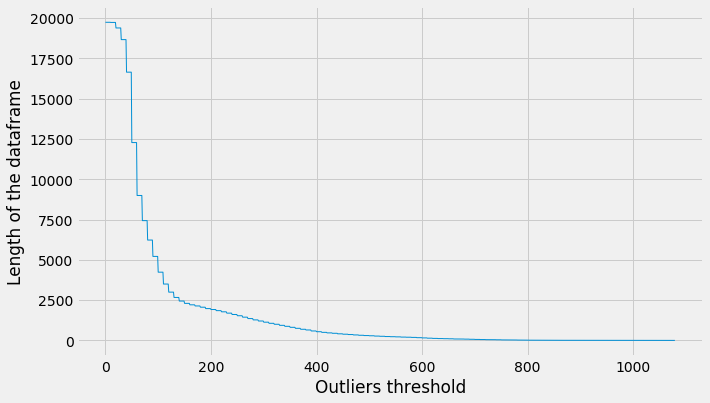

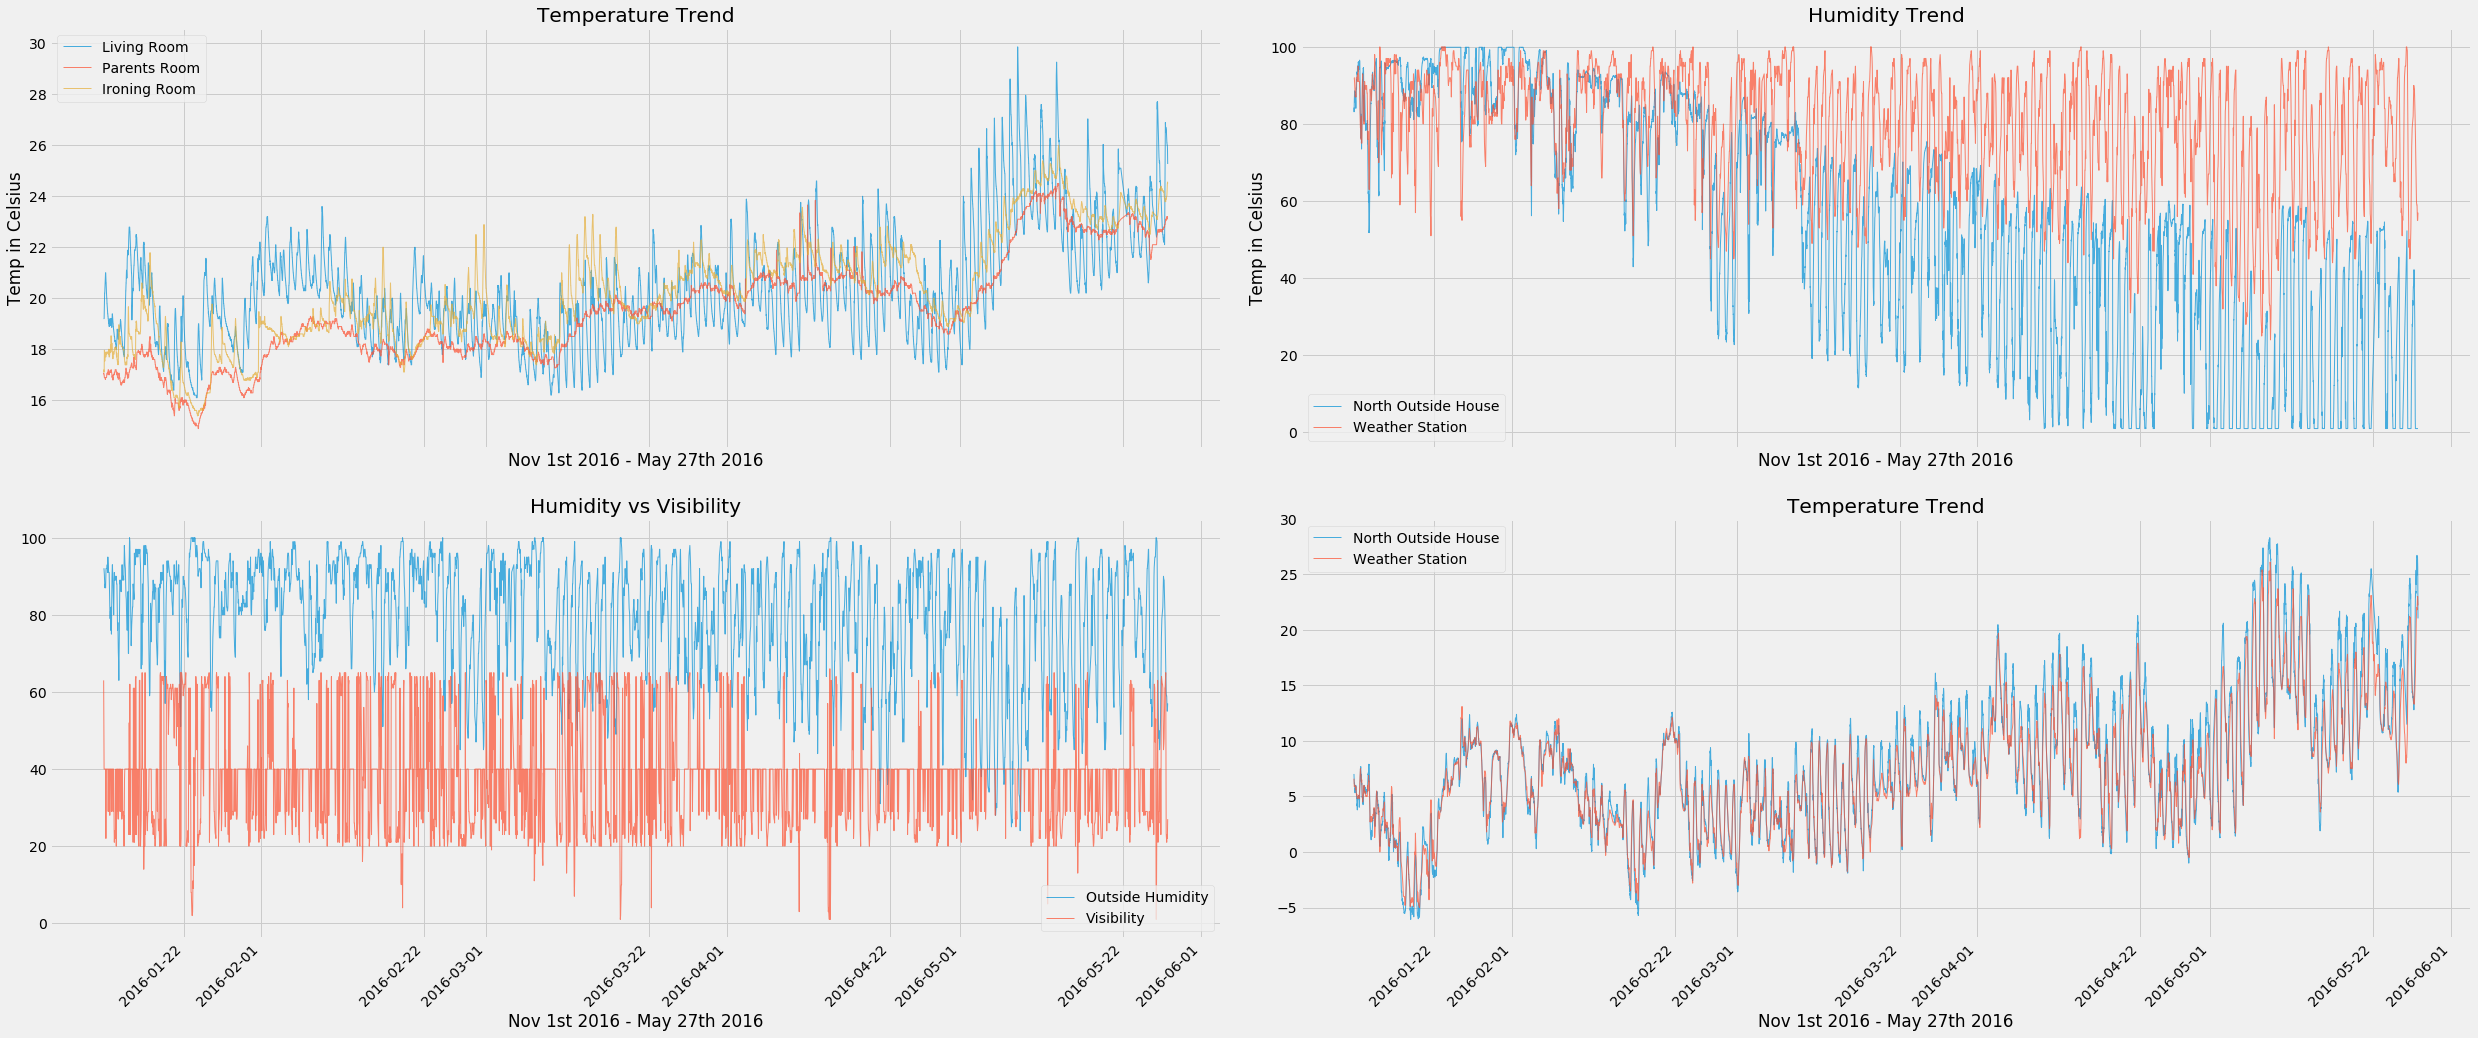

In [4]:
lengs = [ len(data) - len( data.drop(data[(data.appliance_wh > x)].index) )  for x in range(max(data.appliance_wh)) ]
plt.style.use('fivethirtyeight')
plt.figure(figsize = (10,6))
plt.plot(range(len(lengs)), lengs, linewidth = 1)
plt.xlabel('Outliers threshold'); plt.ylabel('Length of the dataframe')
print(lengs[399], lengs[599], lengs[699], lengs[789], sep = ", ")
viz.plot_1(data)
data2 = data.copy()
data = data.drop(data[(data.appliance_wh > 600)|(data.appliance_wh < 0)].index)
data = data.reset_index()
data = data.drop(["index", "light_wh", "date"], axis = 1)
data.shape

In [ ]:
# Histogram of all the features to understand the distribution
plt.style.use('fivethirtyeight')
data.hist(bins = 20 , figsize = (12,16))

In [ ]:
plt.figure(figsize = (18,8)); sns.heatmap(data.corr(), annot = True)

### Target, Features and Train Size
Set the target and the features matrices, with the train size equal to the $3/4$ of the sample size

In [5]:
X = data.drop("appliance_wh", axis = 1).values
y = data.appliance_wh
y_log = np.log(data.appliance_wh)

X = X.reshape( (len(X), len(X[0])))
y = y.values.reshape( len(y), 1)
y_log = y_log.values.reshape( len(y), 1)
print(y.shape, X.shape)

train_size = int(len(X)*0.75)
X_train = X[:train_size]
X_test  = X[train_size:]
y_train = y[:train_size]
y_test  = y[train_size:]
y_train_tree = y_log[:train_size]
y_test_tree  = y_log[train_size:]
print(train_size, len(X) - train_size)

(19580, 1) (19580, 26)
14685 4895


## LINEAR MODEL

R^2 =  0.14897
MSE: 6504.40011
Reducing features with LASSO 
	 ## Remaining features: 15 
	 ## R^2 after reduction: 0.20226

Reducing features with Recursive Feature Elimination 
	 ## Remaining features: 14 
	 ## R^2 after reduction: 0.19309



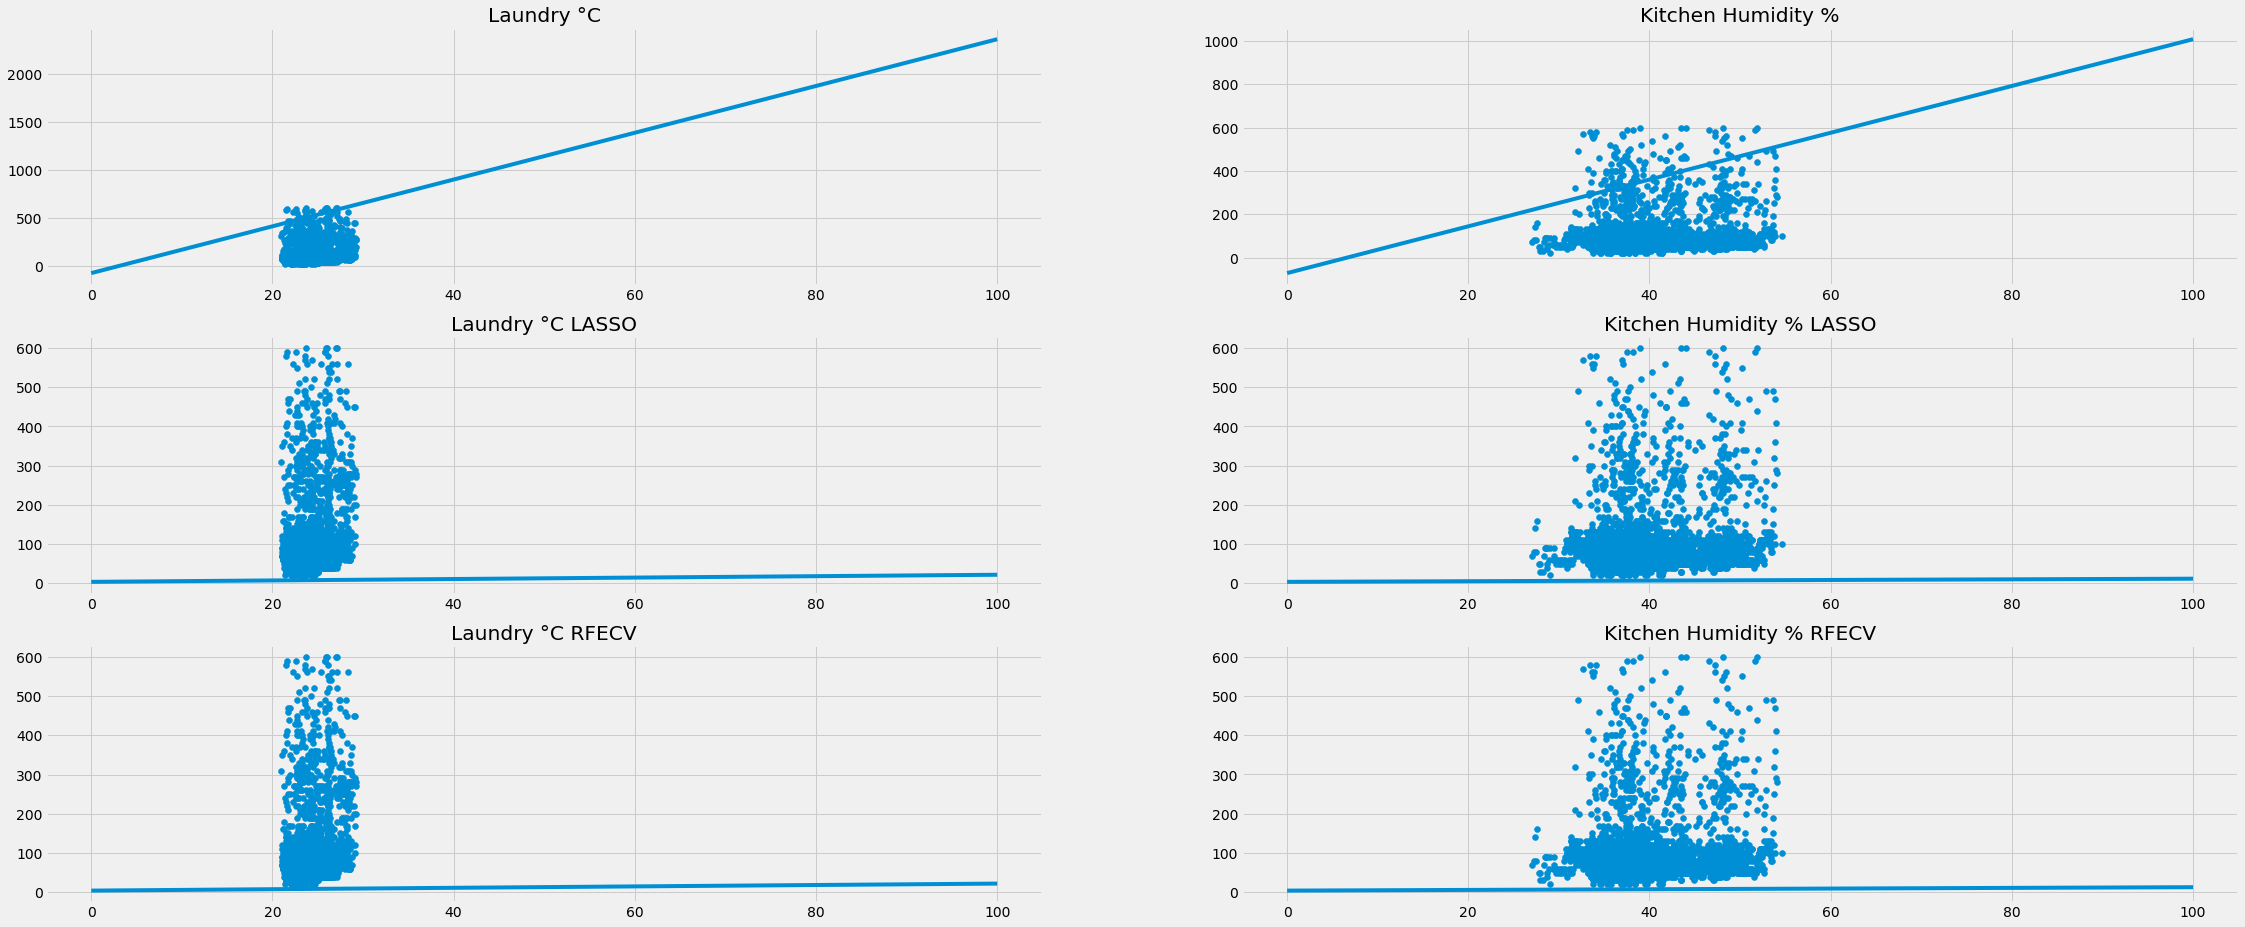

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

model = LinearRegression(fit_intercept = True, n_jobs = -1)
model.fit(X_train, y_train)

y_pred = model.predict(X)
print("R^2 = ", round(r2_score(y, y_pred), 5))
print("MSE:", round(mean_squared_error(y, y_pred), 5))

lasso = lin_mod.lasso(data, X, y)
recursive = lin_mod.recurs_elimin(data, X, y)
viz.plot_2(data, model, lasso, recursive)

In [7]:
from sklearn.linear_model import SGDRegressor
sgd = SGDRegressor(loss = "squared_loss", fit_intercept = True, random_state = 123, learning_rate = "optimal")
sgd.fit(X_train, y_train)

print("R^2 = ", round(r2_score(y, sgd.predict(X)), 5) )
print("MSE:", round(mean_squared_error(y, sgd.predict(X)), 5))

R^2 =  -1.270657764725851e+27
MSE: 9.711581006570566e+30


## POLYNOMIAL MODEL

In [8]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree = 2, include_bias = False, interaction_only = True)
features_polynomial = poly.fit_transform(X_train)

model_2 = LinearRegression(fit_intercept = True)
model_2.fit(features_polynomial, y_train)

y_pred_2 = model_2.predict( poly.transform(X) )
print("R^2 = ", round(r2_score(y, y_pred_2), 5) )
print("MSE:", round(mean_squared_error(y, y_pred_2), 5))

R^2 =  0.06331
MSE: 7159.09984


In [9]:
from sklearn.svm import SVR

supp = SVR(kernel = 'poly', degree = 2)
supp.fit(X_train, y_train)

print("R^2 = ", round(r2_score(y, supp.predict(X)), 5) )
print("MSE:", round(mean_squared_error(y, supp.predict(X)), 5))

R^2 =  -0.10779
MSE: 8466.82443


## DECISION TREE REGRESSOR

In [11]:
decisiontree = DecisionTreeRegressor()
model_tree = decisiontree.fit(X_train, y_train_tree)
tree_pred = model_tree.predict(X_test)

tree_par = opt_tree.evaluate(y_test_tree, tree_pred)
tree_imp = opt_tree.dtr_importance(data, model_tree)
print("Parameteres currently in use:")
pprint(decisiontree.get_params())

Model Performance
MAE: 0.69215
MSE: 0.82744
Variance: 0.45548
Accuracy: 82.4 %

                     values
living_celsius     0.097680
teen_hum_perc      0.076870
laundry_celsius    0.057853
bathroom_hum_perc  0.053755
teen_celsius       0.051707

Parameteres currently in use:
{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}


### Parameter tuning for Decision Tree

In [12]:
tree_tuned = DecisionTreeRegressor(ccp_alpha = 1, criterion = "mse", max_depth = 2,
                                   max_features = 13, max_leaf_nodes = 4, min_impurity_decrease = 0.009,
                                   min_impurity_split = 0.446, min_samples_leaf = 0.1, min_samples_split = 2,
                                   min_weight_fraction_leaf = 0.2, random_state = 529, splitter = "random")
model_tuned = tree_tuned.fit(X_train, y_train_tree)
tuned_pred = model_tuned.predict(X_test)

tuned_par = opt_tree.evaluate(y_test_tree, tuned_pred)

Model Performance
MAE: 0.38582
MSE: 0.29281
Variance: 0.0
Accuracy: 91.48 %



### AdaBoosting and Bagging of the Tree Regressor

In [13]:
from sklearn.ensemble import AdaBoostRegressor
adaboost = AdaBoostRegressor(base_estimator = tree_tuned, loss = "linear", random_state = 981)
boost_model = adaboost.fit(X_train, y_train_tree)
adaboost_pred = boost_model.predict(X_test)

tuned_par = opt_tree.evaluate(y_test_tree, adaboost_pred)

Model Performance
MAE: 0.46572
MSE: 0.32687
Variance: 0.0
Accuracy: 89.13 %



In [14]:
from sklearn.ensemble import BaggingRegressor

bagged = BaggingRegressor(base_estimator = tree_tuned)
bagg_model = bagged.fit(X_train, y_train_tree)
bagg_pred = bagg_model.predict(X_test)

tuned_par = opt_tree.evaluate(y_test_tree, bagg_pred)

Model Performance
MAE: 0.38611
MSE: 0.29267
Variance: 0.0
Accuracy: 91.47 %



## RANDOM FOREST REGRESSOR

In [15]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 1000, random_state = 1234)
rf_model = rf.fit(X_train, y_train_tree)
rf_pred = rf.predict(X_test)

rf_par = opt_tree.evaluate(y_test_tree, rf_pred)
rf_imp = opt_tree.dtr_importance(data, rf_model)
print("Parameters currently in use:")
pprint(rf.get_params())

Model Performance
MAE: 0.58701
MSE: 0.48287
Variance: 0.12586
Accuracy: 84.6 %

                     values
living_celsius     0.099477
teen_hum_perc      0.069520
parents_hum_perc   0.063291
kitchen_hum_perc   0.057107
bathroom_hum_perc  0.052009

Parameters currently in use:
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1234,
 'verbose': 0,
 'warm_start': False}


### Selection of the 8 most important features

In [18]:
imp_feats = ["living_celsius", "teen_hum_perc", "parents_hum_perc", "kitchen_hum_perc",
             "bathroom_hum_perc", "laundry_hum_perc", "teen_celsius", "portico_hum_perc"]
feat_drop = [x for x in data.columns if x not in imp_feats]

X_rf = data.drop(feat_drop, axis = 1).values
X_rf = X_rf.reshape( (len(X_rf), len(X_rf[0])))
#X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_log, test_size = 0.25, random_state = 1234)

X_train_rf =  X_rf[:train_size]
X_test_rf = X_rf[train_size:]

### Parameter tuning for Random Forest Regressor

Chunk 1: Parameters are chosen after RandomizedSearchCV

In [19]:
rf_tuned = RandomForestRegressor(n_estimators = 1000, min_samples_split = 5, min_samples_leaf = 1,
                                 max_features = 'sqrt', max_depth = None, bootstrap = False)
model_rf_tuned = rf_tuned.fit(X_train_rf, y_train_tree)
rf_tuned_pred = model_rf_tuned.predict(X_test_rf)

tuned_par_rf = opt_tree.evaluate(y_test_tree, rf_tuned_pred)

Model Performance
MAE: 0.51863
MSE: 0.39107
Variance: 0.09055
Accuracy: 86.31 %



Chunk 2: Parameters are chosen after GridSearchCV

In [21]:
rf_tun_2 = RandomForestRegressor(n_estimators = 800, min_samples_split = 2, min_samples_leaf = 1,
                                 max_features = 'sqrt', max_depth = None, bootstrap = False)
model_rf_tun_2 = rf_tun_2.fit(X_train_rf, y_train_tree)
rf_tun_2_pred = model_rf_tun_2.predict(X_test_rf)

tuned_par_rf = opt_tree.evaluate(y_test_tree, rf_tun_2_pred)

Model Performance
MAE: 0.51592
MSE: 0.38711
Variance: 0.0895
Accuracy: 86.33 %



## Forest with ```LightGBM```

In [43]:
lgb_train = lgb.Dataset(X_train_rf, y_train_tree)
lgb_eval = lgb.Dataset(X_test_rf, y_test_tree, reference = lgb_train)

forest = lgb.LGBMRegressor(boosting_type = 'rf', objective = "regression", metric = ["l1","l2"],
                           num_leaves = 300, max_depth = 500, learning_rate = 0.0001, num_iterations = 600,
                           feature_fraction = 0.9, bagging_fraction = 0.8, bagging_freq = 5, verbose = 0,
                           min_child_weight = 30, min_split_gain = 0.001)

forest.fit(X_train_rf, y_train_tree)
for_pred = forest.predict(X_test_rf)

for_par = opt_tree.evaluate(y_test_tree, for_pred)

Model Performance
MAE: 0.46327
MSE: 0.34038
Variance: 0.08344
Accuracy: 87.94 %



In [69]:
# fine tuning hyperparameters
def hyp_lgbm(num_leaves, 
             feature_fraction, 
             bagging_fraction,
             max_depth, 
             min_split_gain, 
             min_child_weight):
    
    # Default parameters
    params = {"application" : "regression", "num_iterations" : 5000,"learning_rate" :0.05,
              "early_stopping_round" : 50,"metric" :'l1'}
    
    # adding parameters aka fine tuning 
    params["num_leaves"] = int(round(num_leaves))
    params['feature_fraction'] = max(min(feature_fraction, 1), 0)
    params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
    params['max_depth'] = int(round(max_depth))
    params['min_split_gain'] = min_split_gain
    params['min_child_weight'] = min_child_weight
    # Cross Validation technique
    cv_result = lgb.cv(params, lgb_train, nfold=5, seed=7, 
                       stratified=False, 
                       verbose_eval=None,
                       metrics= ['l2'])
    
    # Objective function will return negative of l1, that's why the minus before 
    return -np.min(cv_result['l2-mean'])

In [70]:
pds = {'num_leaves': (300, 500),
       'feature_fraction': (0.1, 0.9),
       'bagging_fraction': (0.8, 1),
       'max_depth': (500, 1000),
       'min_split_gain': (0.001, 0.1),
       'min_child_weight': (30, 50),
      }

In [71]:
from bayes_opt import BayesianOptimization
# Surrogate model
optimizer = BayesianOptimization(hyp_lgbm, pds)
                                  
# Optimize
optimizer.maximize(init_points = 5, n_iter = 15)

|   iter    |  target   | baggin... | featur... | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------
|  1        | -0.0      |  0.9099   |  0.2594   |  577.0    |  49.18    |  0.01506  |  440.7    |
|  2        | -0.0      |  0.9908   |  0.7056   |  827.8    |  44.25    |  0.07772  |  381.8    |
|  3        | -0.0      |  0.9121   |  0.2641   |  847.4    |  45.78    |  0.05122  |  403.6    |
|  4        | -0.0      |  0.9669   |  0.5601   |  903.7    |  34.27    |  0.05116  |  418.4    |
|  5        | -0.0      |  0.9217   |  0.8497   |  684.9    |  49.6     |  0.00329  |  461.1    |
|  6        | -0.0      |  0.8553   |  0.353    |  503.5    |  38.4     |  0.01226  |  300.2    |
|  7        | -0.0      |  0.9031   |  0.818    |  997.7    |  35.52    |  0.03607  |  300.6    |
|  8        | -0.0      |  0.9151   |  0.7332   |  999.1    |  34.59    |  0.05863  |  497.7    |
|  9        | -0.0  

In [72]:
optimizer.max["params"]

{'bagging_fraction': 0.9098668552439991,
 'feature_fraction': 0.2594495558555633,
 'max_depth': 576.9856527297768,
 'min_child_weight': 49.18058416772932,
 'min_split_gain': 0.015059098306286368,
 'num_leaves': 440.72275973220053}

In [66]:
forest_2 = lgb.LGBMRegressor(boosting_type = 'rf', objective = "regression", metric = ['l2', 'l1'],
                             num_leaves = 440, max_depth = 752,
                             learning_rate = 0.0001, num_iterations = 600, feature_fraction = 0.30908802314596395,
                             bagging_fraction = 0.8376848054627992, bagging_freq = 5, verbose = 0,
                             min_child_weight = 30.803558747467385, min_split_gain = 0.08407521026838967)

forest_2.fit(X_train_rf, y_train_tree)
for_pred_2 = forest_2.predict(X_test_rf)

for_par_2 = opt_tree.evaluate(y_test_tree, for_pred_2)

Model Performance
MAE: 0.39993
MSE: 0.27583
Variance: 0.02217
Accuracy: 89.93 %



# --------------------------------------------------------------------------------------------------------

## Neural Network

In [ ]:
!pip uninstall keras

In [ ]:
import tensorflow
tensorflow.__version__

In [ ]:
# Load libraries
from keras import models
from keras import layers
# Start neural network
network = models.Sequential()
# Add fully connected layer with a ReLU activation function
network.add(layers.Dense(units=16, activation="relu", input_shape=(10,)))
# Add fully connected layer with a ReLU activation function
network.add(layers.Dense(units=16, activation="relu"))
# Add fully connected layer with a sigmoid activation function
network.add(layers.Dense(units=1, activation="sigmoid"))
# Compile neural network
network.compile(loss="binary_crossentropy", # Cross-entropy
                optimizer="rmsprop", # Root Mean Square Propagation
                metrics=["accuracy"]) # Accuracy performance metric